In [2]:
import preprocessing_pipeline as pp
import mne
import numpy as np
import pickle

In [51]:
def load_raw_data(path):
    raw = pp.load_eeg_data(path, eeg_format="cnt", use_montage_creator=True, montage_type='standard_1020')
    raw = pp.add_stimulus_to_raw(raw)
    raw = pp.bandpass_filter(raw)
    raw = pp.average_rereference(raw)
    raw = pp.average_rereference(raw)
    ica_tool = pp.ICAChannelSelection(n_component=20, data=raw)  # You may adjust `n_component` based on your needs.
    ica_tool.fit_ica()
    combined_artifacts = ica_tool.find_combined_artifacts()

    # Apply ICA to remove the identified artifact components
    cleaned_data = ica_tool.apply_ica(combined_artifacts)
    cleaned_data = cleaned_data.pick_types(eeg=True)

    events = mne.find_events(cleaned_data, stim_channel='STI')
    return cleaned_data, events

In [52]:
def get_need_to_search_event_times(events):
    #Load in the IDs specific to word displays, as well as NeedToSearch conditional IDs
    SearchIDs = [21,22,23,24,25,26,27,28,29,30,31,32,33,4,5,6,9]

    events_times = mne.pick_events(events,include=SearchIDs)
    events_times = np.where(events_times == 4, 34, events_times) #Change 4 & 5 to 34 & 35 to allow loop to run
    events_times = np.where(events_times == 5, 35, events_times)
    events_times = np.where(events_times == 6, 36, events_times) #Change 6 & 9 to 34 & 35 to allow loop to run
    events_times = np.where(events_times == 9, 37, events_times)

    #Segment all trials into lists of events
    event_sequence_list = []
    event_sequence = []
    event_id_max = 0
    for x in events_times:
        event_info = x
        event_id = event_info[2]
        #print(event_id_max)
        if event_id > event_id_max:
            event_id_max = event_id
            event_sequence.append(event_info)
        else:
            event_sequence_list.append(event_sequence)
            event_sequence = []
            event_id_max = 0

    #Find all trials that contain both 34 and 35 e.g. NeedToSearch conditions
    NeedToSearchEventTimes = []
    CorrectEventTimes = []
    InCorrectEventTimes = []
    for event in event_sequence_list:
        event_sequence = event
        if any(36 and 37 in array for array in event_sequence) == True:
            NeedToSearchEventTimes.append(event_sequence)
        elif any(34 in array for array in event_sequence) == True:
            CorrectEventTimes.append(event_sequence)
        elif any(35 in array for array in event_sequence) == True:
            InCorrectEventTimes.append(event_sequence)

    return NeedToSearchEventTimes, CorrectEventTimes, InCorrectEventTimes



In [53]:
def get_eeg_time_segments(raw, EventTimes):
    raw_copy = raw.copy()
    sample_rate = 500 #TODO - get this from raw
    eeg_segments = []
    egg_event_ids = []
    for event_sequence in EventTimes:
        EEG_event_sequence = []
        EEG_event_ids = []
        for event in event_sequence:
            start_index = event[0]
            end_index = int(start_index + (0.8 * sample_rate))
            #end_index = int(start_index + (0.8*sample_rate))
            cropped_data = raw_copy[:, start_index:end_index]
            EEG_event_sequence.append(cropped_data)
            EEG_event_ids.append(event[2])
        eeg_segments.append(EEG_event_sequence)
        egg_event_ids.append(EEG_event_ids)
    return eeg_segments, egg_event_ids

Reading 0 ... 3507399  =      0.000 ...  7014.798 secs...


C:\Users\gxb18167\PycharmProjects\SIGIR_EEG_GAN\Development\Information-Need\Improved_Scripts\preprocessing_pipeline.py:137: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(file, preload=preload)
C:\Users\gxb18167\PycharmProjects\SIGIR_EEG_GAN\Development\Information-Need\Improved_Scripts\preprocessing_pipeline.py:53: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['A1', 'A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  self.raw.set_montage(montage)


Creating RawArray with float64 data, n_channels=1, n_times=3507400
    Range : 0 ... 3507399 =      0.000 ...  7014.798 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.25 Hz)
- Filter length: 16501 samples (33.002 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done  34 out of  34 | elapsed:   13.8s finished


Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 34 channels (please be patient, this may take a while)
Selecting by number: 20 components


C:\Users\gxb18167\PycharmProjects\SIGIR_EEG_GAN\Development\Information-Need\Improved_Scripts\preprocessing_pipeline.py:291: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (22) and smallest (8.2e-07) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  self.ica.fit(self.data)


Fitting ICA took 118.5s.
Error while processing ECG artifact: Unable to generate artificial ECG channel
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


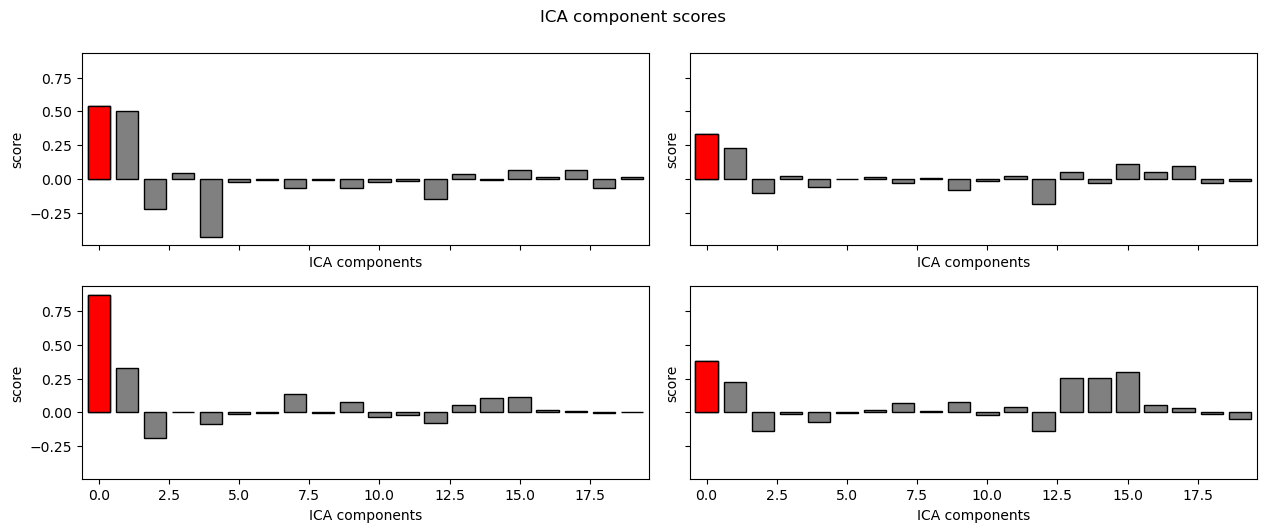

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
3507 matching events found
No baseline correction applied
0 projection items activated


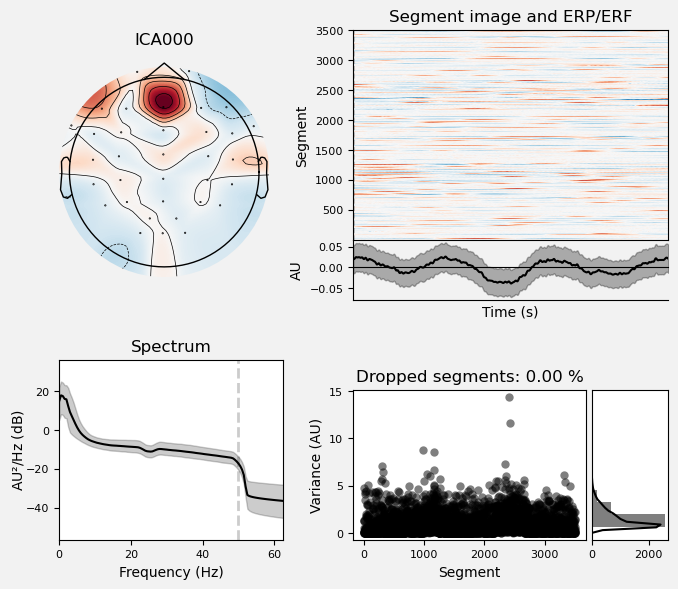

Creating RawArray with float64 data, n_channels=24, n_times=3507400
    Range : 0 ... 3507399 =      0.000 ...  7014.798 secs
Ready.
Using matplotlib as 2D backend.


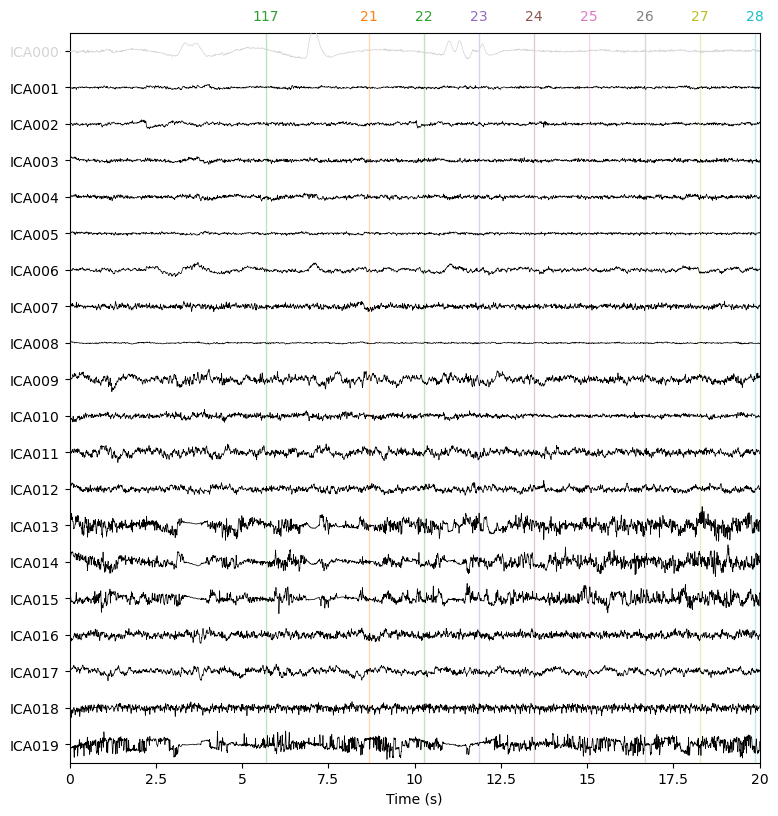

Effective window size : 0.512 (s)


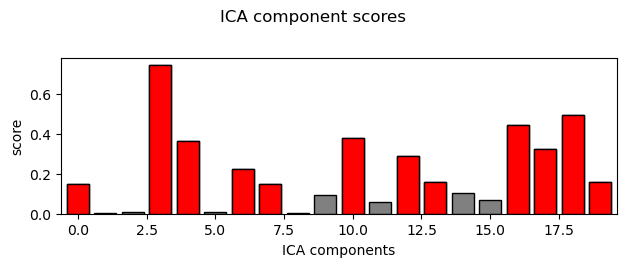

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
3507 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3507 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3507 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3507 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3507 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3507 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3507 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3507 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3507 matching events found
No baseline correction appl

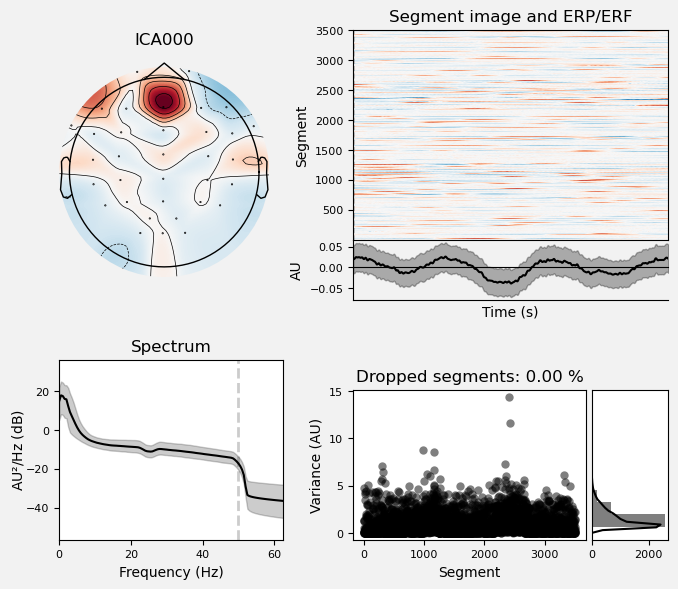

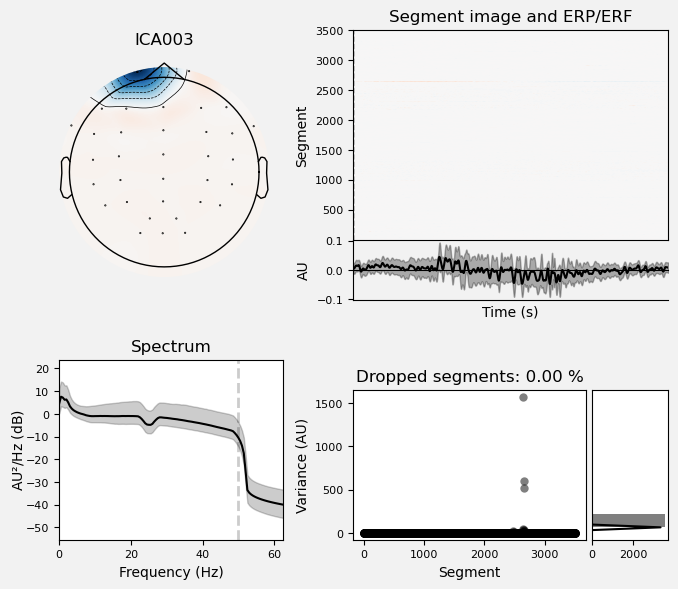

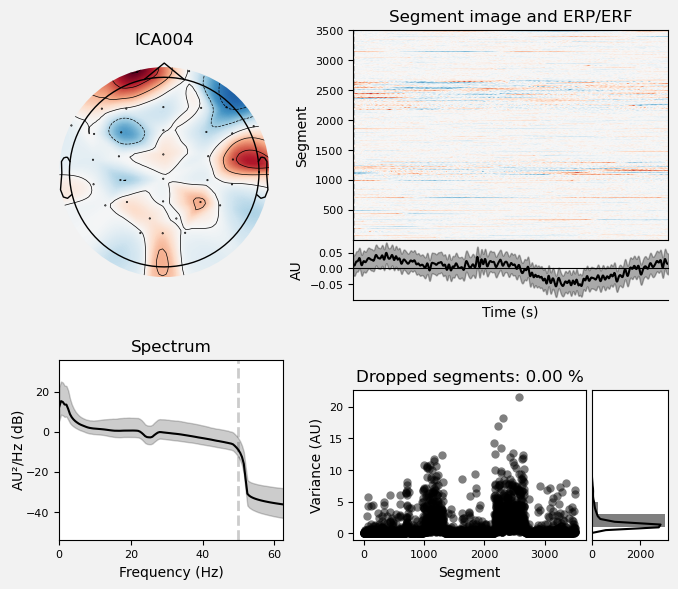

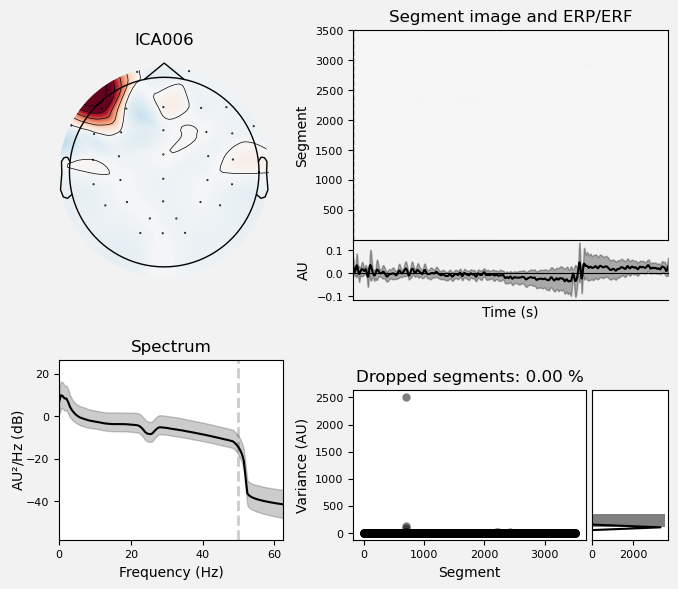

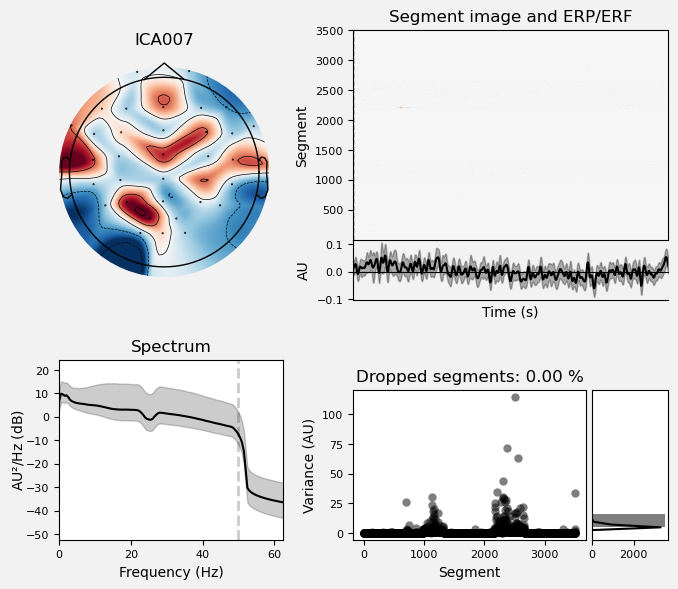

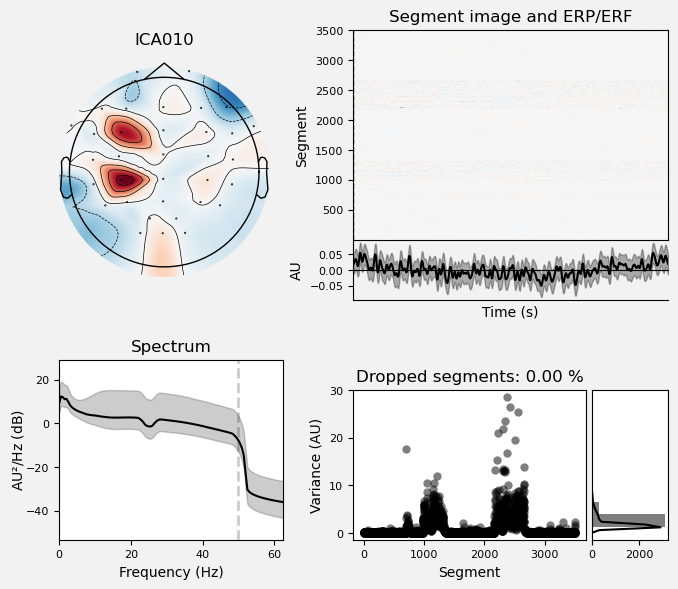

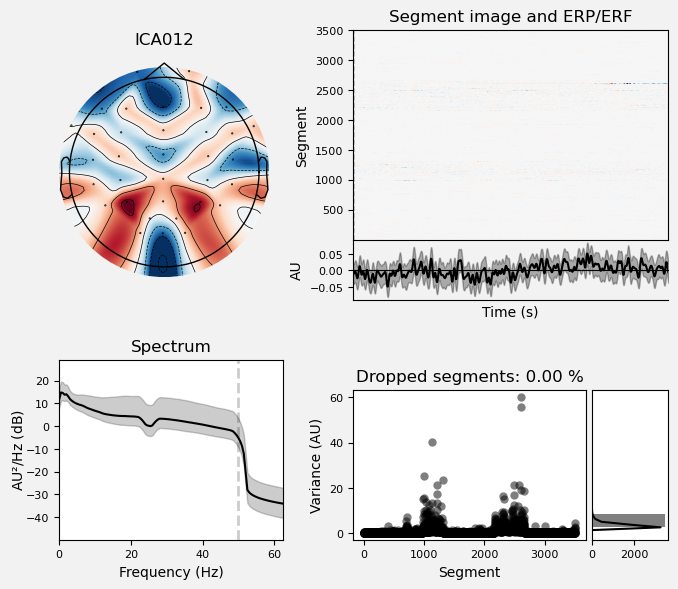

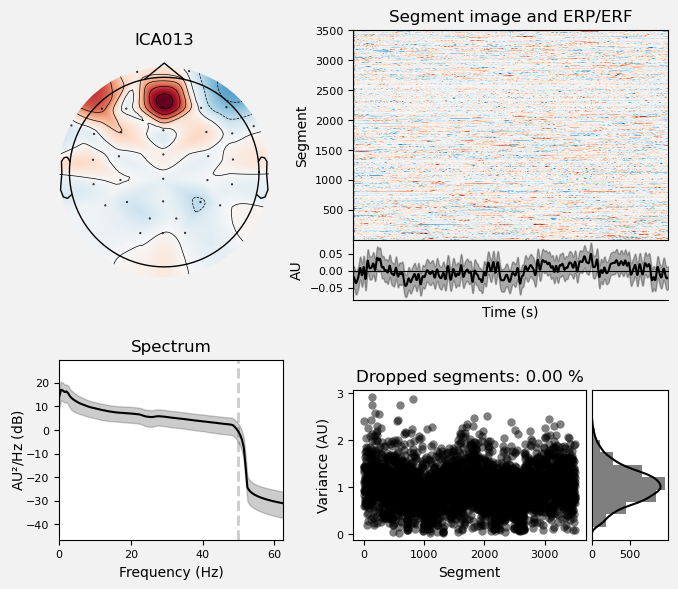

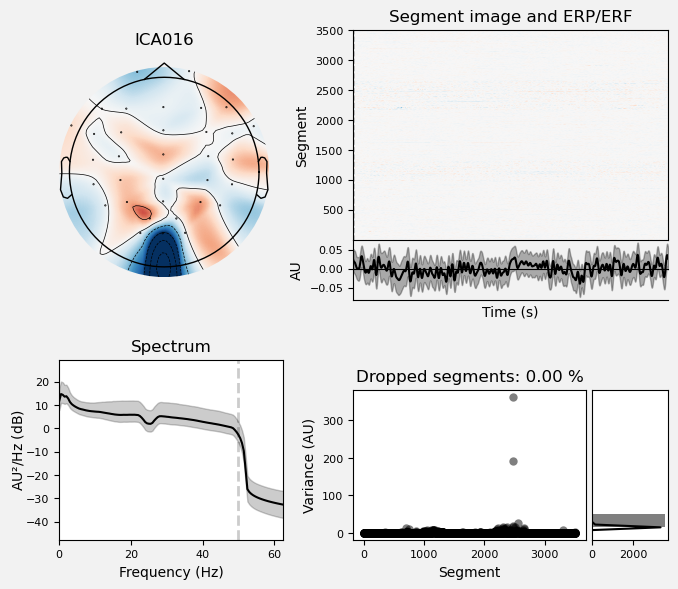

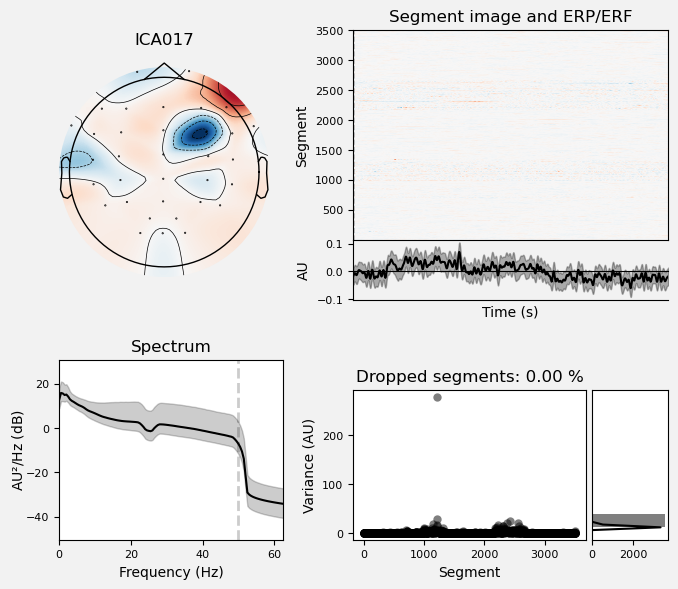

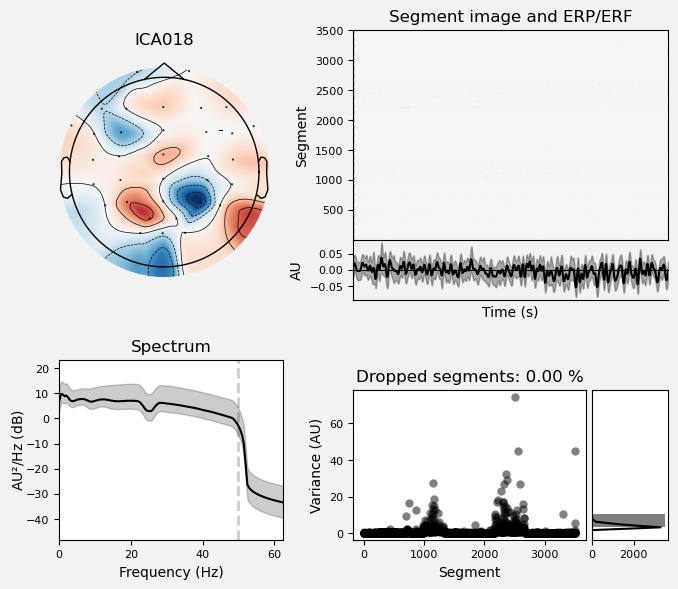

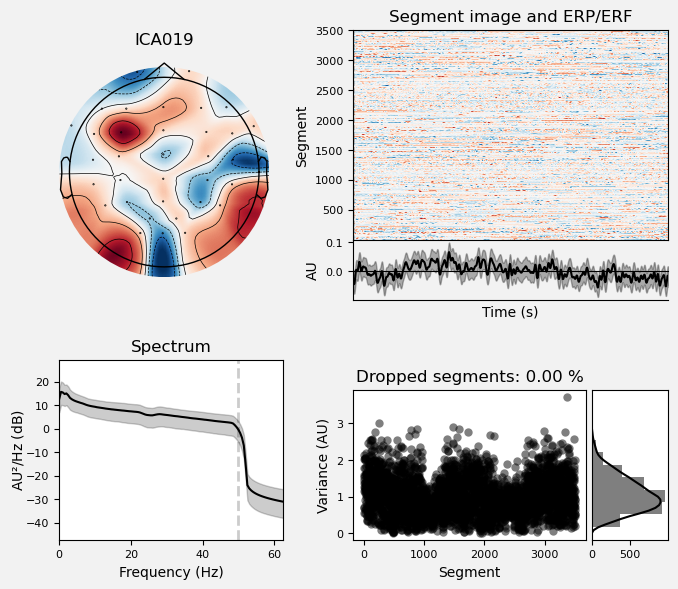

Creating RawArray with float64 data, n_channels=24, n_times=3507400
    Range : 0 ... 3507399 =      0.000 ...  7014.798 secs
Ready.


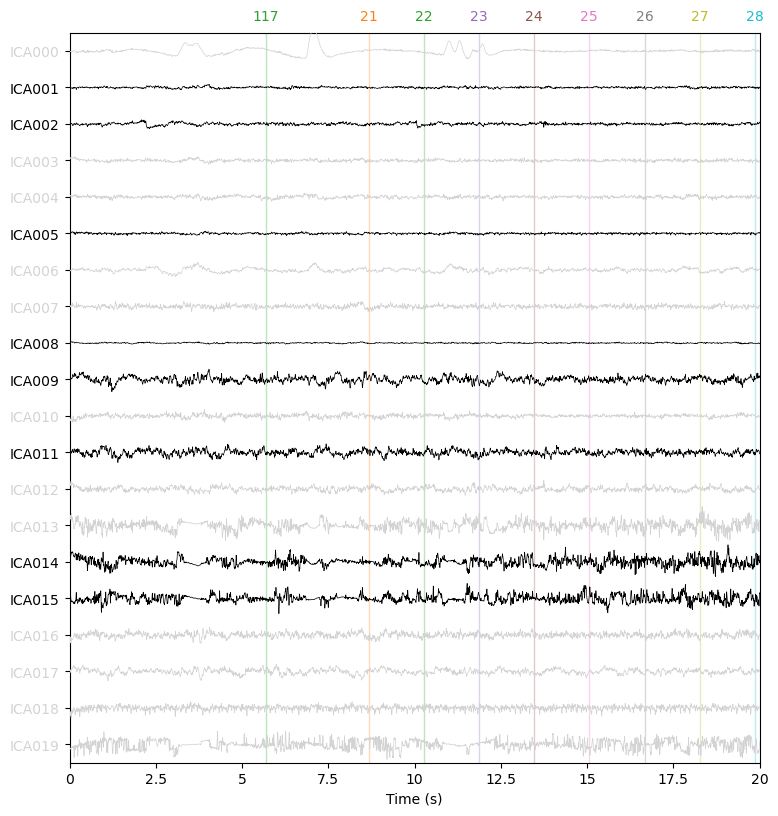

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 12 ICA components
    Projecting back using 34 PCA components
1839 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  20  21  22  23
  24  25  26  27  28  29  30  31  32  33  34  35  36  39  44  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 173 174 175]


In [54]:
path = fr"I:\Science\CIS-YASHMOSH\niallmcguire\dominika\Raw Data\001\001.cnt"
raw, events = load_raw_data(path)

In [55]:
raw

<RawCNT | 001.cnt, 41 x 3507400 (7014.8 s), ~1.07 GB, data loaded>

<RawCNT | 001.cnt, 34 x 3507400 (7014.8 s), ~909.9 MB, data loaded>

In [29]:
NeedToSearchEventTimes, CorrectEventTimes, InCorrectEventTimes  = get_need_to_search_event_times(events)

In [30]:
len(NeedToSearchEventTimes)

18

In [36]:
NeedToSearchEEGSegments = get_eeg_time_segments(raw, NeedToSearchEventTimes)

In [49]:
len(NeedToSearchEEGSegments[0][0])

9